#### Messages to prompt

The easiest way to ensure your LLM receives a conversation correctly formatted is to use the `chat_template` from the model’s tokenizer.

In [1]:
messages = [
    {"role": "system", "content": "You are an AI assistant with access to various tools."},
    {"role": "user", "content": "Hi !"},
    {"role": "assistant", "content": "Hi human, what can help you with ?"},
]

To convert the previous conversation into a prompt, we load the tokenizer and call `apply_chat_template`:

In [2]:
from transformers import AutoTokenizer

model_name = "HuggingFaceTB/SmolLM2-1.7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

rendered_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

print(rendered_prompt)

<|im_start|>system
You are an AI assistant with access to various tools.<|im_end|>
<|im_start|>user
Hi !<|im_end|>
<|im_start|>assistant
Hi human, what can help you with ?<|im_end|>
<|im_start|>assistant



###  Auto-formatting Tool sections

We will implement a simplified calculator tool that will just multiply two integers. This could be our Python implementation:

```python
def calculator(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b
```

We will leverage Python’s introspection features to leverage the source code and build a tool description automatically for us. All we need is that the tool implementation uses type hints, docstrings, and sensible function names. We will write some code to extract the relevant portions from the source code.

```python
@tool
def calculator(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

print(calculator.to_string())
```

In [4]:
def calculator(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

#### Generic Tool implementation

We create a generic Tool class that we can reuse whenever we need to use a tool.

It may seem complicated, but if we go slowly through it we can see what it does. We define a Tool class that includes:

- `name (str)`: The name of the tool.
- `description (str)`: A brief description of what the tool does.
- `function (callable)`: The function the tool executes.
- `arguments (list)`: The expected input parameters.
- `outputs (str or list)`: The expected outputs of the tool.
- `__call__()`: Calls the function when the tool instance is invoked.
- `to_string()`: Converts the tool’s attributes into a textual representation.

We could create a Tool with this class using code like the following:

In [2]:
class Tool:
    """
    A class representing a reusable piece of code (Tool).
    
    Attributes:
        name (str): Name of the tool.
        description (str): A textual description of what the tool does.
        func (callable): The function this tool wraps.
        arguments (list): A list of argument.
        outputs (str or list): The return type(s) of the wrapped function.
    """
    def __init__(self, 
                 name: str, 
                 description: str, 
                 func: callable, 
                 arguments: list,
                 outputs: str):
        self.name = name
        self.description = description
        self.func = func
        self.arguments = arguments
        self.outputs = outputs

    def to_string(self) -> str:
        """
        Return a string representation of the tool, 
        including its name, description, arguments, and outputs.
        """
        args_str = ", ".join([
            f"{arg_name}: {arg_type}" for arg_name, arg_type in self.arguments
        ])
        
        return (
            f"Tool Name: {self.name},"
            f" Description: {self.description},"
            f" Arguments: {args_str},"
            f" Outputs: {self.outputs}"
        )

    def __call__(self, *args, **kwargs):
        """
        Invoke the underlying function (callable) with provided arguments.
        """
        return self.func(*args, **kwargs)

We could create a Tool with this class using code like the following:

In [5]:
calculator_tool = Tool(
    "calculator",                   # name
    "Multiply two integers.",       # description
    calculator,                     # function to call
    [("a", "int"), ("b", "int")],   # inputs (names and types)
    "int",                          # output
)

calculator_tool.to_string()

'Tool Name: calculator, Description: Multiply two integers., Arguments: a: int, b: int, Outputs: int'

But we can also use Python’s `inspect` module to retrieve all the information for us! This is what the `@tool` decorator does.

In [6]:
import inspect

In [7]:
import inspect  # Import inspect module to retrieve function signatures

def tool(func):
    """
    A decorator that creates a Tool instance from the given function.
    
    This decorator extracts metadata from the function, such as its name, 
    parameters, return type, and docstring, and uses this information 
    to create a Tool instance.
    """

    # Get the function signature (parameters and return type)
    signature = inspect.signature(func)

    # Extract (param_name, param_annotation) pairs for function arguments
    arguments = []
    for param in signature.parameters.values():
        # Get the type annotation of the parameter, if available
        annotation_name = (
            param.annotation.__name__  # Extract the name if it's a class/type
            if hasattr(param.annotation, "__name__")
            else str(param.annotation)  # Convert to string otherwise
        )
        arguments.append((param.name, annotation_name))  # Store name and type

    # Determine the return type annotation
    return_annotation = signature.return_annotation
    if return_annotation is inspect._empty:  # No return annotation specified
        outputs = "No return annotation"
    else:
        outputs = (
            return_annotation.__name__  # Extract name if available
            if hasattr(return_annotation, "__name__")
            else str(return_annotation)  # Convert to string otherwise
        )

    # Use the function's docstring as the Tool description (or default text)
    description = func.__doc__ or "No description provided."

    # The function name is used as the Tool name
    name = func.__name__

    # Return a new Tool instance with extracted metadata
    return Tool(
        name=name,  # Tool name (same as function name)
        description=description,  # Tool description (from docstring)
        func=func,  # The original function itself
        arguments=arguments,  # List of function parameters with types
        outputs=outputs  # The return type annotation
    )


Just to reiterate, with this decorator in place we can implement our tool like this:

In [8]:
# The @tool decorator wraps the calculator function and transforms it into an instance of the Tool class instead of a regular function.
# This allows calculator to behave like an object with additional metadata and methods.

@tool
def calculator(a: int, b: int) -> int:
    """Multiply two integers."""
    return a * b

print(calculator.to_string())

Tool Name: calculator, Description: Multiply two integers., Arguments: a: int, b: int, Outputs: int


In [9]:
calculator(3,4)

12

In [10]:
type(calculator)

__main__.Tool

###  Thought: Internal Reasoning and the Re-Act Approach

Thoughts represent the **Agent’s internal reasoning and planning processes** to solve the task.

This utilises the agent’s Large Language Model (LLM) capacity to analyze information when presented in its prompt.

The Agent’s thoughts are responsible for accessing current observations and decide what the next action(s) should be.

Through this process, the agent can break down **complex problems into smaller, more manageable steps**, reflect on past experiences, and continuously adjust its plans based on new information.

Here are some examples of common thoughts:


|No| Type of Thought       | Example                                                                                   |  
|--|-----------------------|-------------------------------------------------------------------------------------------|  
|1| **Planning**         | “I need to break this task into three steps: 1) gather data, 2) analyze trends, 3) generate report” |  
|2| **Analysis**         | “Based on the error message, the issue appears to be with the database connection parameters” |  
|3| **Decision Making**  | “Given the user’s budget constraints, I should recommend the mid-tier option”              |  
|4| **Problem Solving**  | “To optimize this code, I should first profile it to identify bottlenecks”                 |  
|5| **Memory Integration** | “The user mentioned their preference for Python earlier, so I’ll provide examples in Python” |  
|6| **Self-Reflection**  | “My last approach didn’t work well, I should try a different strategy”                      |  
|7| **Goal Setting**     | “To complete this task, I need to first establish the acceptance criteria”                  |  
|8| **Prioritization**   | “The security vulnerability should be addressed before adding new features”                 |

**Note**: *In the case of LLMs fine-tuned for function-calling, the thought process is optional. In case you’re not familiar with function-calling, there will be more details in the Actions section.*

####  The Re-Act Approach

A key method is the **ReAct approach**, which is the concatenation of “Reasoning” (Think) with “Acting” (Act).

ReAct is a simple prompting technique that appends “Let’s think step by step” before letting the LLM decode the next tokens.

Indeed, prompting the model to think “step by step” encourages the decoding process toward next tokens **that generate a plan**, rather than a final solution, since the model is encouraged to decompose the problem into sub-tasks.

This allows the model to consider sub-steps in more detail, which in general leads to less errors than trying to generate the final solution directly.

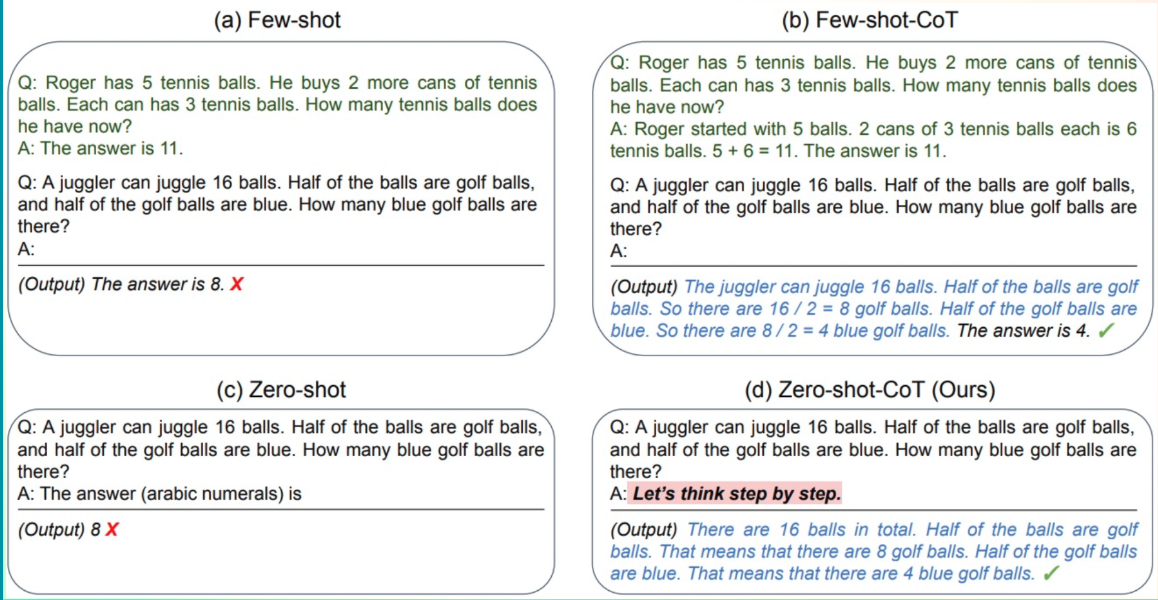

###  Actions: Enabling the Agent to Engage with Its Environment

Actions are the concrete steps an **AI agent takes to interact with its environment**.

Whether it’s browsing the web for information or controlling a physical device, each action is a deliberate operation executed by the agent.

For example, an agent assisting with customer service might retrieve customer data, offer support articles, or transfer issues to a human representative.

####  Types of Agent Actions

There are multiple types of Agents that take actions differently:

| Type of Agent           | Description                                                                               |  
|-------------------------|-------------------------------------------------------------------------------------------|  
| **JSON Agent**          | The Action to take is specified in JSON format.                                          |  
| **Code Agent**          | The Agent writes a code block that is interpreted externally.                            |  
| **Function-calling Agent** | A subcategory of the JSON Agent fine-tuned to generate a new message for each action. |

Actions themselves can serve many purposes:


| Type of Action            | Description                                                              |  
|---------------------------|--------------------------------------------------------------------------|  
| **Information Gathering** | Performing web searches, querying databases, or retrieving documents.   |  
| **Tool Usage**           | Making API calls, running calculations, and executing code.             |  
| **Environment Interaction** | Manipulating digital interfaces or controlling physical devices.      |  
| **Communication**        | Engaging with users via chat or collaborating with other agents.        |  

One crucial part of an agent is the **ability to STOP generating new tokens when an action is complete**, and that is true for all formats of Agent: JSON, code, or function-calling. This prevents unintended output and ensures that the agent’s response is clear and precise.

The LLM only handles text and uses it to describe the action it wants to take and the parameters to supply to the tool.

####  The Stop and Parse Approach

One key method for implementing actions is the **stop and parse approach**. This method ensures that the agent’s output is structured and predictable:

- **Generation in a Structured Format**: The agent outputs its intended action in a clear, predetermined format (JSON or code).
- **Halting Further Generation**: Once the action is complete, **the agent stops generating additional tokens**. This prevents extra or erroneous output.
- **Parsing the Output**: An external parser reads the formatted action, determines which Tool to call, and extracts the required parameters.

For example, an agent needing to check the weather might output:

```
Thought: I need to check the current weather for New York.
Action :
{
  "action": "get_weather",
  "action_input": {"location": "New York"}
}
```

The framework can then easily parse the name of the function to call and the arguments to apply.

The framework can then easily parse the name of the function to call and the arguments to apply.

This clear, machine-readable format minimizes errors and enables external tools to accurately process the agent’s command.

**Note**: *Function-calling agents operate similarly by structuring each action so that a designated function is invoked with the correct arguments. We’ll dive deeper into those types of Agents in a future Unit.*

####  Code Agents

An alternative approach is using Code Agents. The idea is: **instead of outputting a simple JSON object**, a Code Agent generates an **executable code block—typically in a high-level language like Python.**

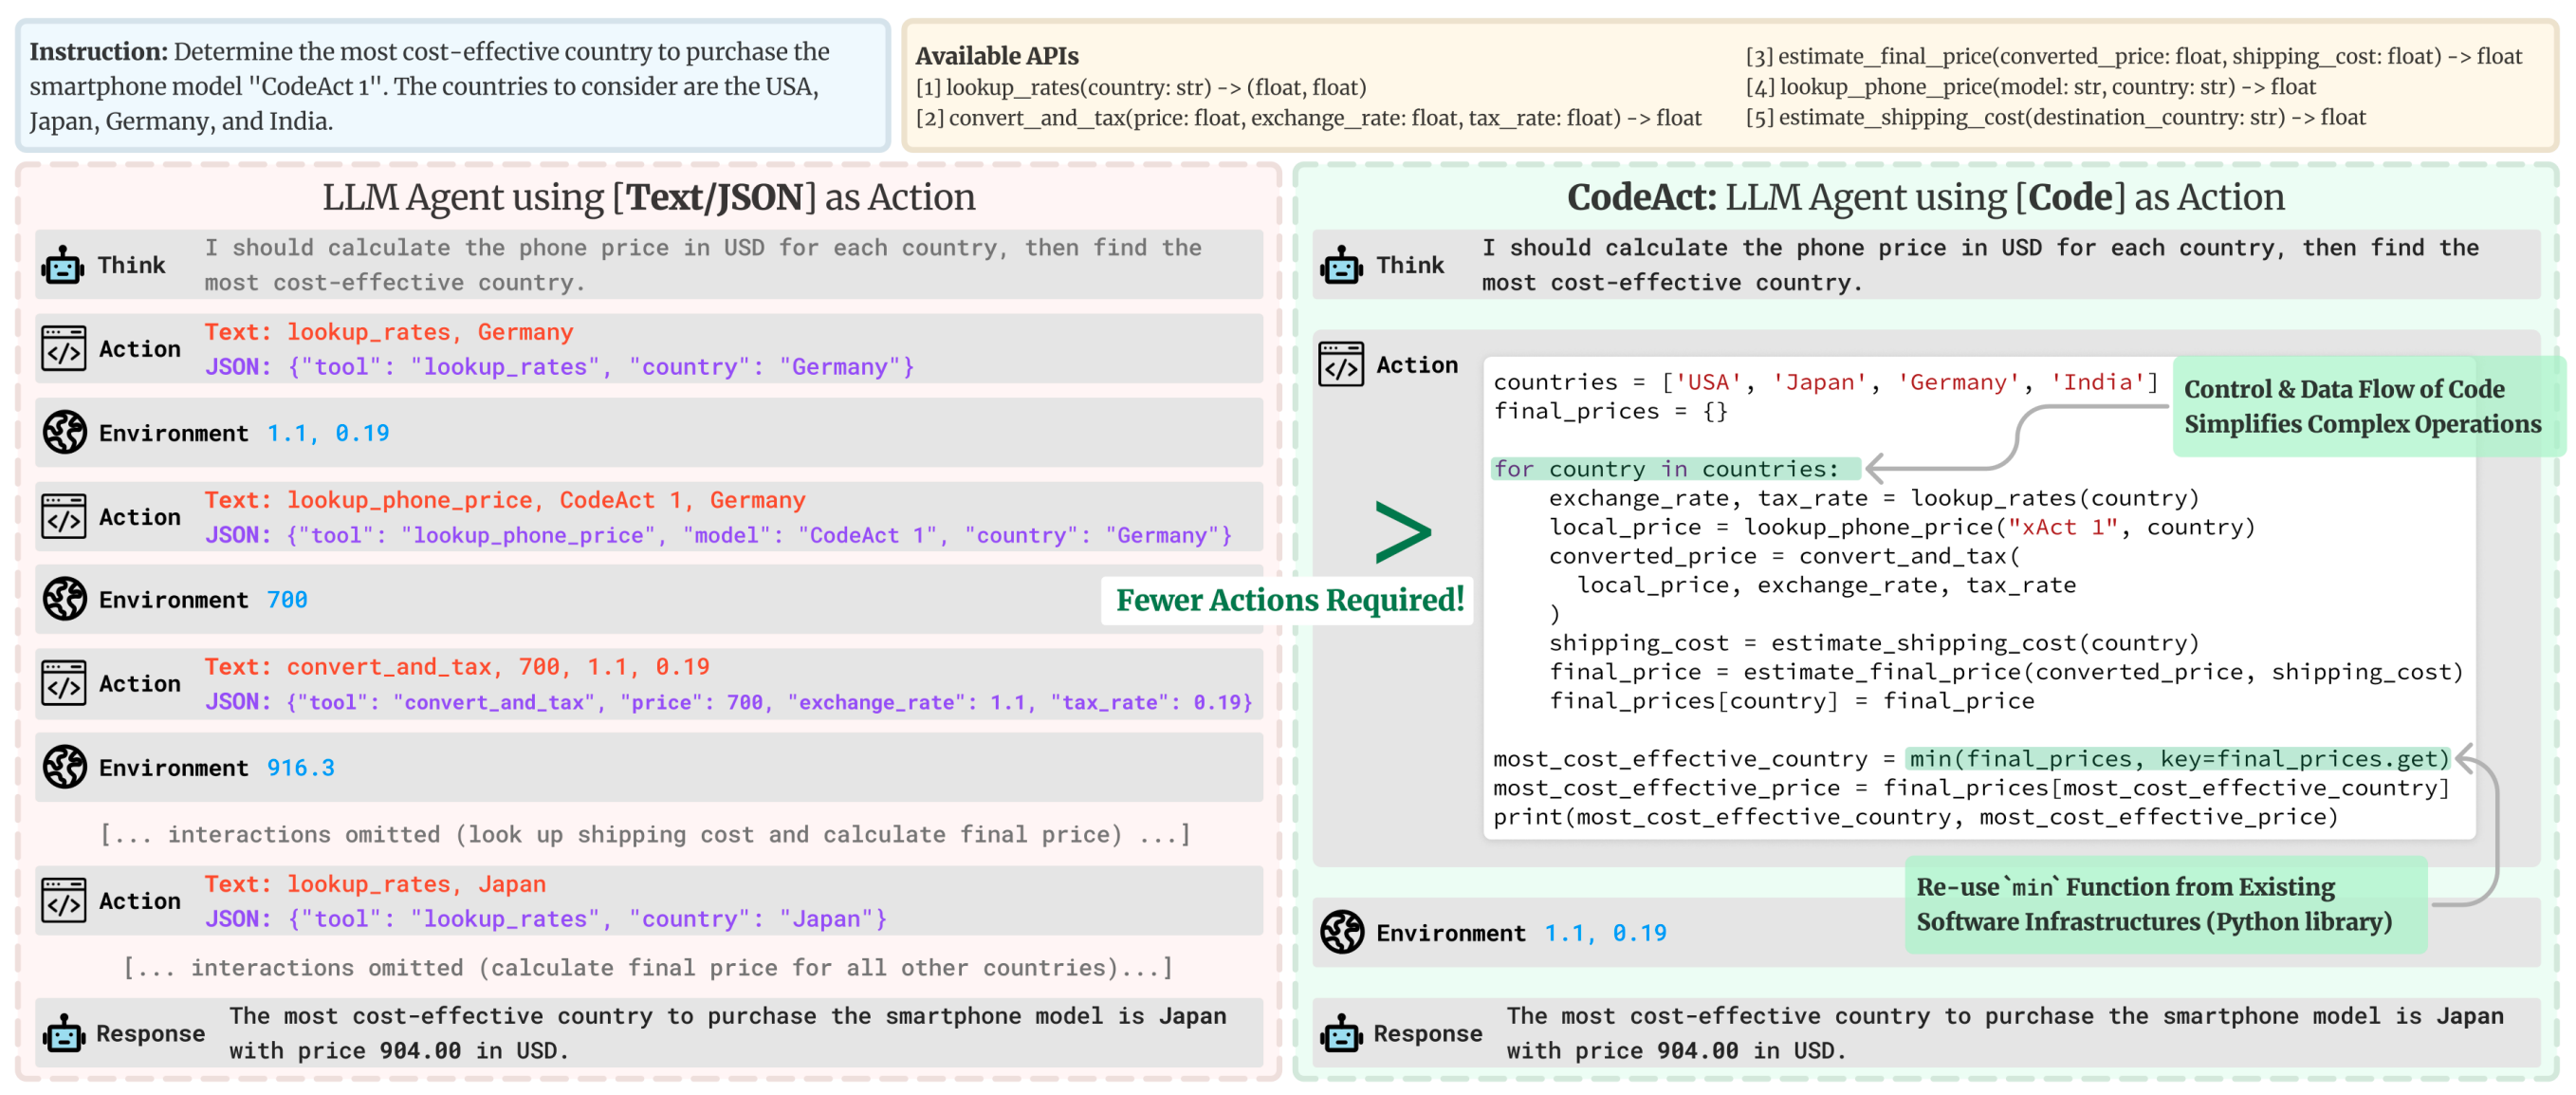


This approach offers several advantages:

- **Expressiveness**: Code can naturally represent complex logic, including loops, conditionals, and nested functions, providing greater flexibility than JSON.
    
- **Modularity and Reusability**: Generated code can include functions and modules that are reusable across different actions or tasks.
    
- **Enhanced Debuggability**: With a well-defined programming syntax, code errors are often easier to detect and correct.
    
- **Direct Integration**: Code Agents can integrate directly with external libraries and APIs, enabling more complex operations such as data processing or real-time decision making.

For example, a Code Agent tasked with fetching the weather might generate the following Python snippet:

```python
# Code Agent Example: Retrieve Weather Information
def get_weather(city):
    import requests
    api_url = f"https://api.weather.com/v1/location/{city}?apiKey=YOUR_API_KEY"
    response = requests.get(api_url)
    if response.status_code == 200:
        data = response.json()
        return data.get("weather", "No weather information available")
    else:
        return "Error: Unable to fetch weather data."

# Execute the function and prepare the final answer
result = get_weather("New York")
final_answer = f"The current weather in New York is: {result}"
print(final_answer)
```

This method **also follows the stop and parse approach** by clearly delimiting the code block and signaling when execution is complete (here, by printing the final_answer).

###  Observe: Integrating Feedback to Reflect and Adapt

Observations are how an **Agent perceives the consequences of its actions.**

They provide crucial information that fuels the Agent’s thought process and guides future actions.

They are **signals from the environment**—whether it’s data from an API, error messages, or system logs—that guide the next cycle of thought.

In the observation phase, the agent:

- **Collects Feedback**: Receives data or confirmation that its action was successful (or not).
- **Appends Results**: Integrates the new information into its existing context, effectively updating its memory.
- **Adapts its Strategy**: Uses this updated context to refine subsequent thoughts and actions.

For example, if a weather API returns the data `“partly cloudy, 15°C, 60% humidity”`, this observation is appended to the agent’s memory (at the end of the prompt).

The Agent then uses it to decide whether additional information is needed or if it’s ready to provide a final answer.

This **iterative incorporation of feedback ensures the agent remains dynamically aligned with its goals**, constantly learning and adjusting based on real-world outcomes.

These observations **can take many forms**, from reading webpage text to monitoring a robot arm’s position. This can be seen like Tool “logs” that provide textual feedback of the Action execution.

| Type of Observation    | Example                                           |  
|------------------------|---------------------------------------------------|  
| **System Feedback**    | Error messages, success notifications, status codes |  
| **Data Changes**       | Database updates, file system modifications, state changes |  
| **Environmental Data** | Sensor readings, system metrics, resource usage  |  
| **Response Analysis**  | API responses, query results, computation outputs |  
| **Time-based Events**  | Deadlines reached, scheduled tasks completed      |

 #### How Are the Results Appended?

 After performing an action, the framework follows these steps in order:

- **Parse the action** to identify the function(s) to call and the argument(s) to use.
- **Execute the action**.
- **Append the result as an Observation**.